# Movie Recommendation Sytem by Collaborative filtering technique

## 1. Importing Libraries and Loading the Dataset

In [1]:
!pip install fuzzywuzzy

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading the dataset

Imdb_user_movie_ratings = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset/IMDB_User_Movie_Ratings.csv')
Imdb_movies = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset/IMDB_Movies.csv')

## 2. Exploratory Data Analysis

In [5]:
n_ratings = len(Imdb_user_movie_ratings)
n_movies = Imdb_user_movie_ratings['movieId'].nunique()
n_users = Imdb_user_movie_ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique Movies: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique Movies: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### Distribution of movie ratings

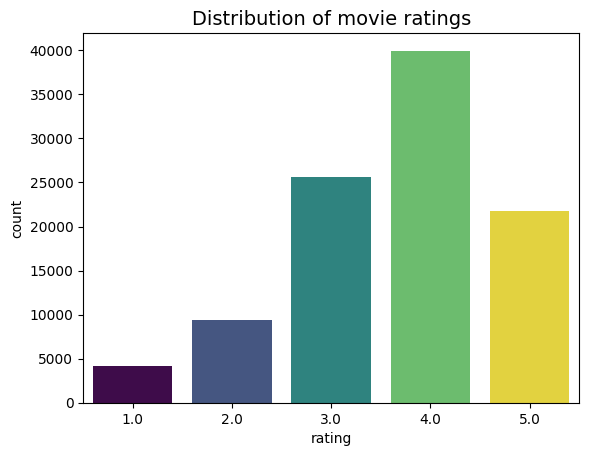

In [6]:
sns.countplot(x="rating", hue="rating", data=Imdb_user_movie_ratings, palette="viridis", legend=False)

plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [7]:
mean_global_rating = Imdb_user_movie_ratings['rating'].mean()
print(f"Mean global rating: {round(mean_global_rating,2)}.")

mean_ratings = Imdb_user_movie_ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.65.
Mean rating per user: 3.78.


## A Glimpse at Movie Genre
The movies dataset needs to be cleaned in two ways:

`genres` is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.

In [8]:
# Using str.split() to extract the genres
Imdb_movies['genres'] = Imdb_movies['genres'].apply(lambda x: x.split('|'))

# Removing the year with help of regular expressions
# Imdb_movies['year'] = Imdb_movies['title'].str.extract(r'\((\d{4})\)')
# Imdb_movies['title'] = Imdb_movies['title'].str.replace(r'\(\d{4}\)', ' ',regex=True).str.strip()

Imdb_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [9]:
# Total no of Movie genres and their count
genre_frequency = Counter(g for genres in Imdb_movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [10]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


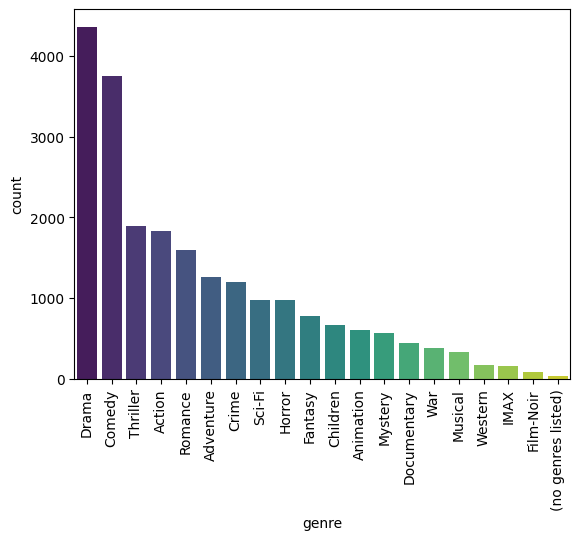

In [11]:
# Visualizing the Genre plot
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False),palette=sns.color_palette("viridis", n_colors=len(genre_frequency_df)))
plt.xticks(rotation=90)
plt.show()

## 3. Popularity Based Recommendation

### Most Frequently Rated movies

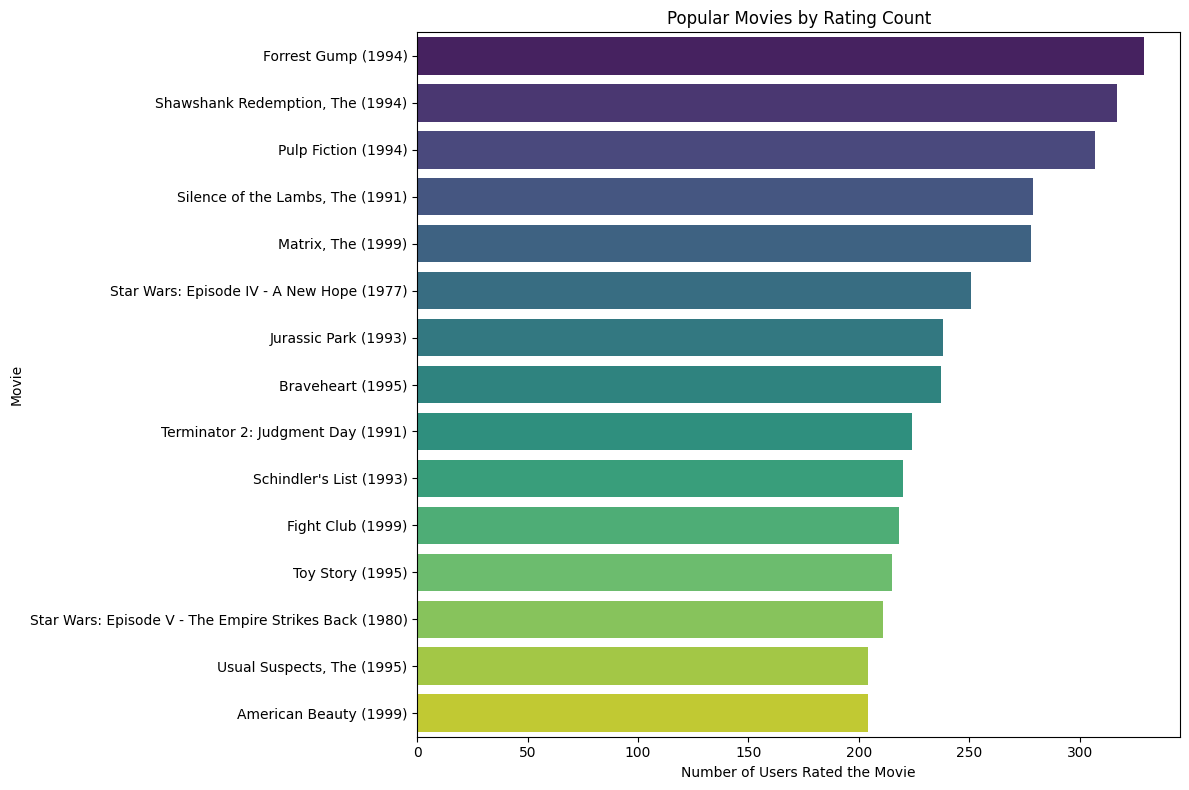

In [57]:
# Merging the two dataframes
movie_ratings = Imdb_user_movie_ratings.merge(Imdb_movies, on='movieId')
ratings_count = movie_ratings.groupby('title').agg(rating_count=('rating', 'count')).reset_index()
ratings_count_sorted = ratings_count.sort_values(by='rating_count', ascending=False)

# Plotting a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=ratings_count_sorted.head(15), y='title', x='rating_count', palette='viridis')

# Add labels and title
plt.ylabel('Movie')
plt.xlabel('Number of Users Rated the Movie')
plt.title('Popular Movies by Rating Count')
plt.tight_layout()

# Show the plot
plt.show()


`The number of ratings alone does not fully capture movie popularity.`

A movie with a high number of ratings might not necessarily be the most popular; it could be that it has been out for a longer time or has been heavily promoted.

For a more accurate measure of popularity, additional metrics like `average ratings`

### Lowest and Highest Rated Movies by Average Rating

In [42]:
mean_ratings = Imdb_user_movie_ratings.groupby('movieId').agg(mean_rating=('rating', 'mean')).reset_index()
mean_ratings = mean_ratings.merge(Imdb_movies[['movieId', 'title']], on='movieId')
mean_ratings

,movieId,mean_rating,title
0,1,4.027907,Toy Story (1995)
1,2,3.581818,Jumanji (1995)
2,3,3.346154,Grumpier Old Men (1995)
3,4,2.428571,Waiting to Exhale (1995)
4,5,3.142857,Father of the Bride Part II (1995)
...,...,...,...
9719,193581,4.000000,Black Butler: Book of the Atlantic (2017)
9720,193583,4.000000,No Game No Life: Zero (2017)
9721,193585,4.000000,Flint (2017)
9722,193587,4.000000,Bungo Stray Dogs: Dead Apple (2018)


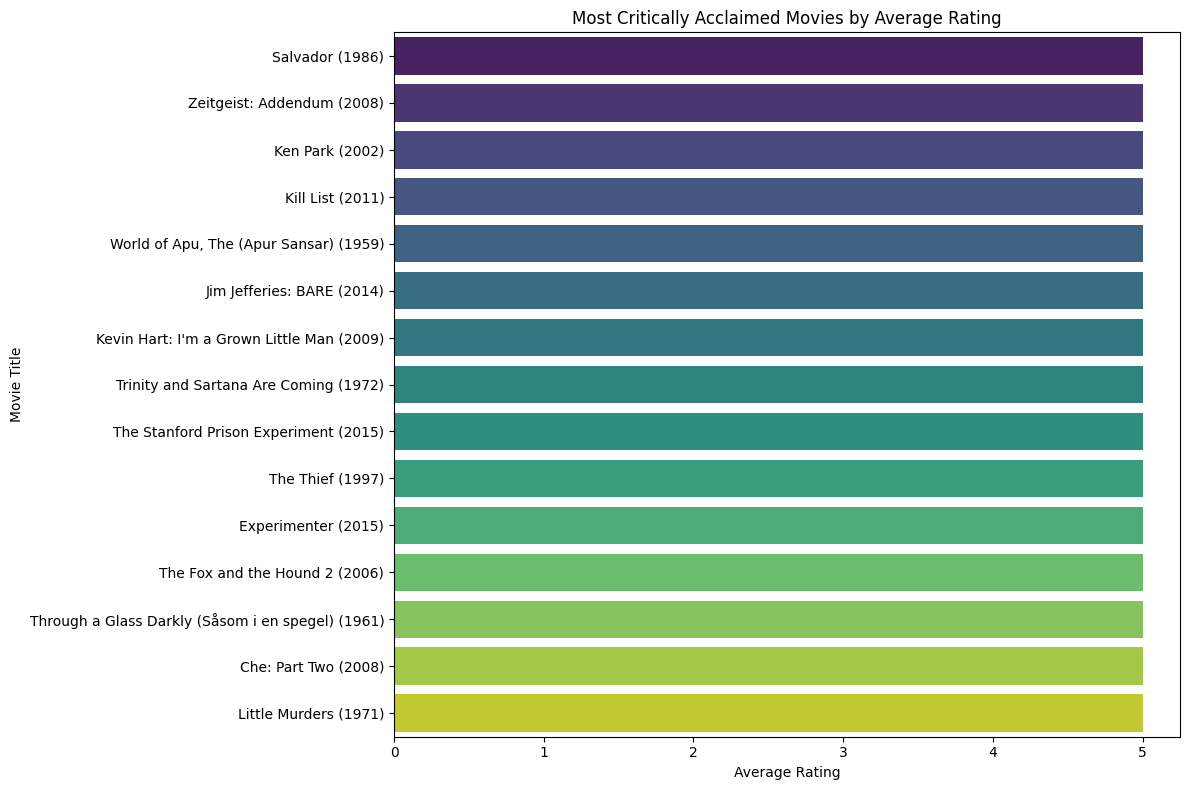

In [44]:
mean_ratings_top = mean_ratings.sort_values(by='mean_rating', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=mean_ratings_top.head(15), y='title', x='mean_rating', palette='viridis')

# Add labels and title
plt.ylabel('Movie')
plt.xlabel('Average Rating')
plt.title('Most Critically Acclaimed Movies by Average Rating')

plt.tight_layout()

# Show the plot
plt.show()

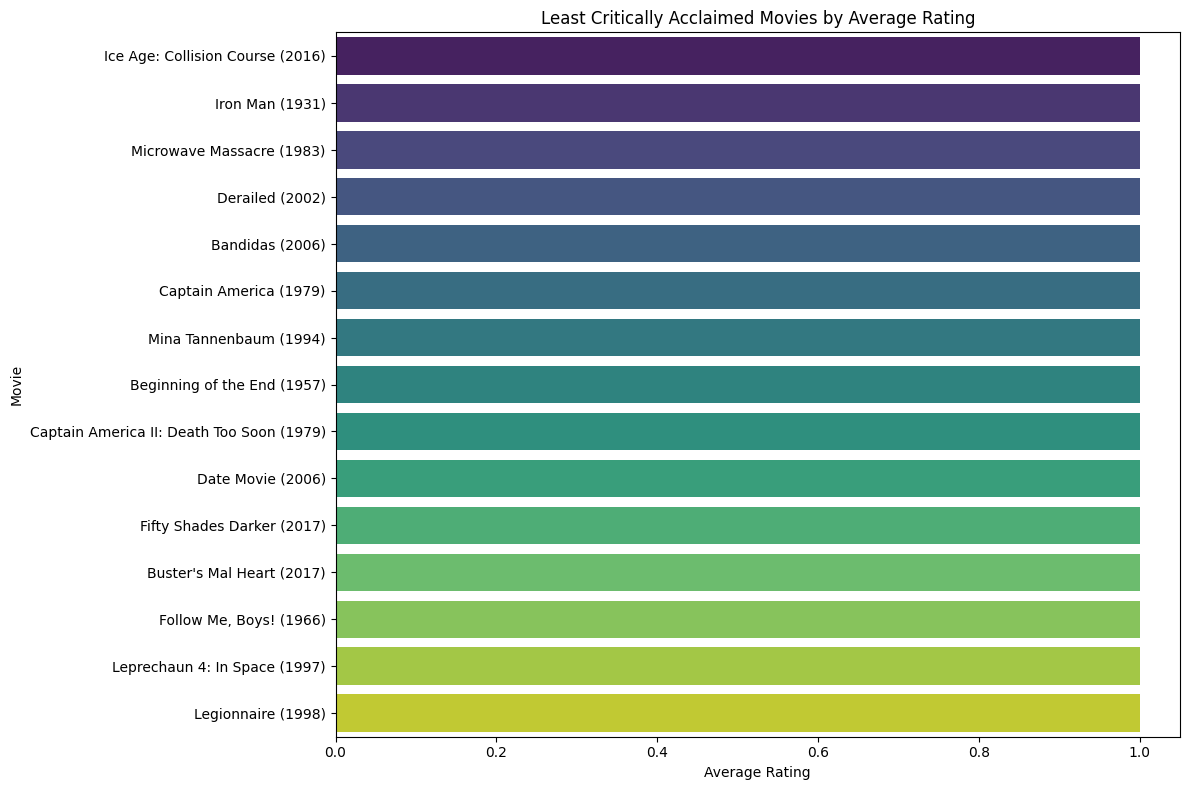

In [45]:
mean_ratings_bottom = mean_ratings.sort_values(by='mean_rating', ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=mean_ratings_bottom.head(15), y='title', x='mean_rating', palette='viridis')

# Add labels and title
plt.ylabel('Movie')
plt.xlabel('Average Rating')
plt.title('Least Critically Acclaimed Movies by Average Rating')

plt.tight_layout()

# Show the plot
plt.show()

In [51]:
# How many users have rated the movie 'Salvador (1986)'
movie_id = Imdb_movies.loc[Imdb_movies['title'] == 'Salvador (1986)', 'movieId'].iloc[0]
Imdb_user_movie_ratings[Imdb_user_movie_ratings['movieId'] == movie_id]

# Well only 1 user has rated it

,userId,movieId,rating,timestamp
26793,182,4407,5.0,1076826019


In [50]:
# How many users have rated the movie 'Iron Man (1931)'
movie_id = Imdb_movies.loc[Imdb_movies['title'] == 'Iron Man (1931)', 'movieId'].iloc[0]
Imdb_user_movie_ratings[Imdb_user_movie_ratings['movieId'] == movie_id]

# Well only 1 user has rated it

,userId,movieId,rating,timestamp
84807,550,167296,1.0,1488728333


`Salvador (1986)` may be the "highest" rated movie, but it only has 1 rating.

Similarly `Iron Man (1931)` may be the "Lowest" rated movie, but it only has 1 rating.

A better approach for evaluating movie popularity is to do look at the `Bayesian average`.



### Movie Popularity by Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{ratings}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of ratings for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [59]:
rating_counts = Imdb_user_movie_ratings.groupby('movieId').agg(rating_count=('rating', 'count')).reset_index()

# Merge mean ratings with rating counts
movie_stats = mean_ratings.merge(rating_counts, on='movieId')

# Reorder columns to include movieId, title, mean_rating, and rating_count
movie_stats = movie_stats[['movieId', 'title', 'mean_rating', 'rating_count']]

movie_stats

,movieId,title,mean_rating,rating_count
0,1,Toy Story (1995),4.027907,215
1,2,Jumanji (1995),3.581818,110
2,3,Grumpier Old Men (1995),3.346154,52
3,4,Waiting to Exhale (1995),2.428571,7
4,5,Father of the Bride Part II (1995),3.142857,49
...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),4.000000,1
9720,193583,No Game No Life: Zero (2017),4.000000,1
9721,193585,Flint (2017),4.000000,1
9722,193587,Bungo Stray Dogs: Dead Apple (2018),4.000000,1


In [61]:
C = movie_stats['rating_count'].mean()
m = movie_stats['mean_rating'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.44


In [63]:
# Our bayesian average function
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

# Apllying bayesiang average on our datasest
bayesian_avg_ratings = Imdb_user_movie_ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats

,movieId,title,mean_rating,rating_count,bayesian_avg
0,1,Toy Story (1995),4.027907,215,4.001
1,2,Jumanji (1995),3.581818,110,3.570
2,3,Grumpier Old Men (1995),3.346154,52,3.362
3,4,Waiting to Exhale (1995),2.428571,7,3.033
4,5,Father of the Bride Part II (1995),3.142857,49,3.195
...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),4.000000,1,3.490
9720,193583,No Game No Life: Zero (2017),4.000000,1,3.490
9721,193585,Flint (2017),4.000000,1,3.490
9722,193587,Bungo Stray Dogs: Dead Apple (2018),4.000000,1,3.490


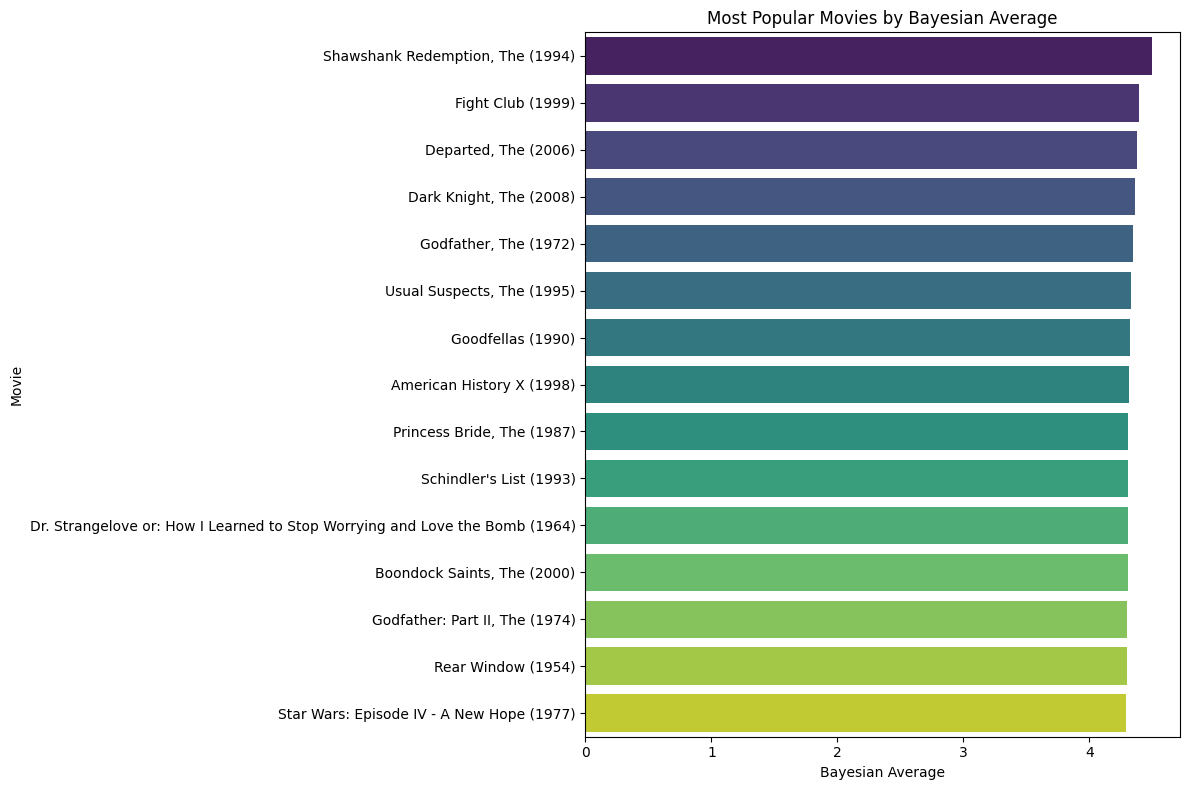

In [67]:
movie_stats_bayesianAvg_top = movie_stats.sort_values(by='bayesian_avg', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=movie_stats_bayesianAvg_top.head(15), y='title', x='bayesian_avg', palette='viridis')

plt.ylabel('Movie')
plt.xlabel('Bayesian Average')
plt.title('Most Popular Movies by Bayesian Average')

plt.tight_layout()

plt.show()

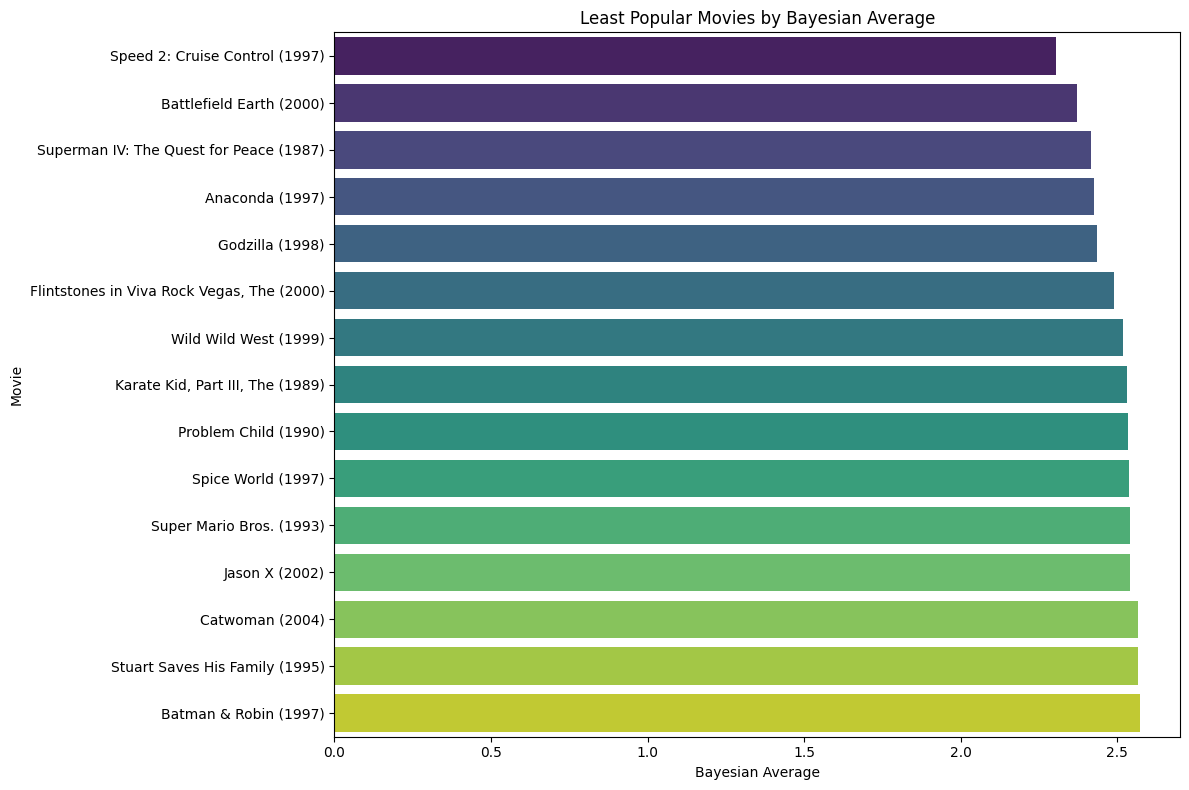

In [68]:
movie_stats_bayesianAvg_bottom = movie_stats.sort_values(by='bayesian_avg', ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=movie_stats_bayesianAvg_bottom.head(15), y='title', x='bayesian_avg', palette='viridis')

plt.ylabel('Movie')
plt.xlabel('Bayesian Average')
plt.title('Least Popular Movies by Bayesian Average')

plt.tight_layout()

plt.show()

## 4. Data Pre-Processing for Collaborative Filtering

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a `utility` matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="images/user_movie_matrix.png" width=50%/>

In [17]:
'''
The create_utility_matrix() function generates a sparse matrix X along with four dictionary mappings:

user_mapper: Associates each user ID with a corresponding user index.
movie_mapper: Associates each movie ID with a corresponding movie index.
user_inv_mapper: Provides a reverse mapping from user index back to the original user ID.
movie_inv_mapper: Provides a reverse mapping from movie index back to the original movie ID.

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.
'''

# Sparse Matrix: Only stores non-zero values and their indices, making it memory-efficient for large matrices with few non-zero elements.

def build_utility_matrix(df):

    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_indices = list(range(N))
    movie_indices = list(range(M))

    # Mapping unique userIDs and movieIDs to integer indices
    user_mapper = dict(zip(np.unique(df["userId"]), user_indices))
    movie_mapper = dict(zip(np.unique(df["movieId"]), movie_indices))

    # Reverse mapping from integer indices back to the original IDs
    user_inv_mapper = dict(zip(user_indices, np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(movie_indices, np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    # Constructing the utility matrix as a sparse matrix
    X = csr_matrix((df["rating"], (user_index,movie_index)), shape=(N,M))
    # row -> users
    # columns -> movies

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = build_utility_matrix(Imdb_user_movie_ratings)

In [18]:
# print(X)
print(X.shape)

# X.nnz returns No of Non-Zero elements
NNZ = X.nnz

# print(n_ratings) -> 100836
# The sparsity of a matrix refers to the proportion of zero elements in the matrix
total_elements = X.shape[0] * X.shape[1]
sparsity_ratio = 1 - (NNZ / total_elements)
print(f"Sparsity of Matrix: {round(sparsity_ratio*100,2)}%")

(610, 9724)
Sparsity of Matrix: 98.3%


In [19]:
'''
Checking for Cold Start Problem
The cold start problem is when there are new users and movies in our matrix that do not have any ratings.
'''

#  Number of non-zero elements per row
n_ratings_per_user = X.getnnz(axis=1)
print(len(n_ratings_per_user))
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

610
Most active user rated 2698 movies.
Least active user rated 20 movies.


In [20]:
#  Number of non-zero elements per column
n_ratings_per_movie = X.getnnz(axis=0)

print(len(n_ratings_per_movie))
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

9724
Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


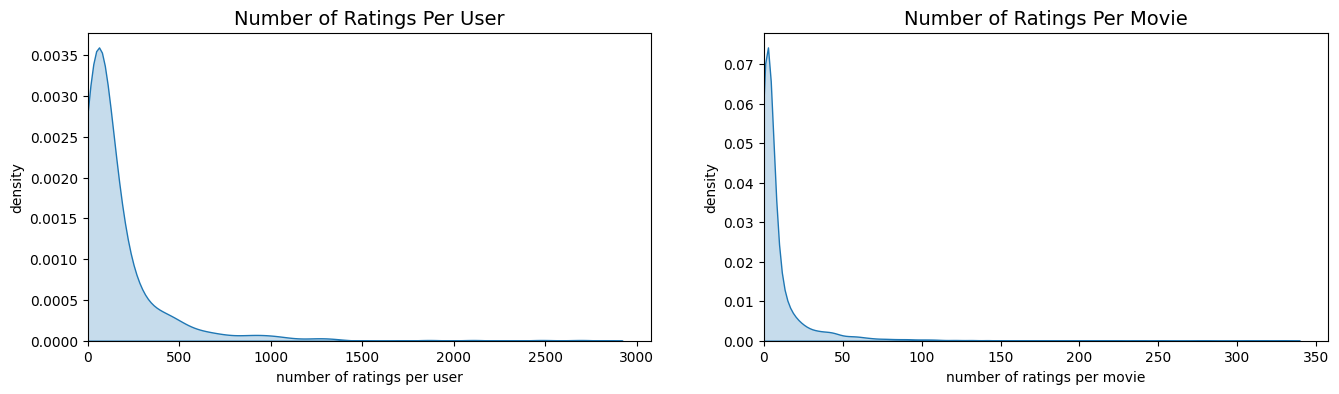

In [21]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")

plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

## 5. Collaborative Filtering Technique: k-Nearest Neighbors for Movie Recommendations (Item-Item Based)

In [22]:
# We are going to find the k movies that have the most similar user engagement vectors for movie

# find_similar_movies() takes in a movieId and X matrix, and outputs a list of  k  movies that are similar to the movieId of interest.
def find_similar_movies(movie_id, X, k, movie_mapper=movie_mapper, movie_inv_mapper=movie_inv_mapper, metric='cosine'):

    X = X.T
    neighbour_ids = []

    movie_idx = movie_mapper.get(movie_id)
    if movie_idx is None:
        raise ValueError(f"Movie ID {movie_id} not found in movie_mapper.")

    movie_vec = X[movie_idx]

    # Convert movie_vec to a 2D array
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)

    knn = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    knn.fit(X)

    # Find k nearest neighbors
    distances, indices = knn.kneighbors(movie_vec, return_distance=True)

    similar_movie_ids = [movie_inv_mapper[idx] for idx in indices.flatten()]

    similar_movie_ids.pop(0)

    return similar_movie_ids,distances.flatten()[1:]


In [23]:
similar_movies, distances = find_similar_movies(1, X, k=10)
print(similar_movies)
print(distances)

[3114, 480, 780, 260, 356, 364, 1210, 648, 4306, 1265]
[0.42103395 0.43025257 0.43711216 0.44137969 0.44781784 0.45256495
 0.45594301 0.46047843 0.46081393 0.46623854]


In [24]:
movie_titles = dict(zip(Imdb_movies['movieId'], Imdb_movies['title']))

movie_id = 1

similar_movies, _ = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Shrek (2001)
Groundhog Day (1993)


In [25]:
# Using Euclidean Distance as metric
movie_id = 1

similar_movies, _ = find_similar_movies(movie_id, X, k=10,metric='euclidean')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Bug's Life, A (1998)
Independence Day (a.k.a. ID4) (1996)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Mask, The (1994)
Groundhog Day (1993)
Honey, I Shrunk the Kids (1989)


Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, jumanji is actually listed as 'Jumanji (1995)'. If we misspell  jumanji, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in.

Creating a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [26]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = Imdb_movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [27]:
movie_title = movie_finder("jumndi")
print(movie_title)
movie_id = Imdb_movies.loc[Imdb_movies['title'] == movie_title, 'movieId'].iloc[0]
print(movie_id)

Jumanji (1995)
2


In [28]:
# Try with an example
movie_title = input('Enter a movie You have watched and want similar recommendations : ')
movie_title = movie_finder(movie_title)
movie_id = Imdb_movies.loc[Imdb_movies['title'] == movie_title, 'movieId'].iloc[0]

similar_movies, _ = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print()
print(f"Because you watched '{movie_title}', similar recommendations are:")
for i in similar_movies:
    print(movie_titles[i])

Enter a movie You have watched and want similar recommendations : tou stry

Because you watched 'Toy Story (1995)', similar recommendations are:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Shrek (2001)
Groundhog Day (1993)


## 6. Dimensionality Reduction with Matrix Factorization